## 1. 서론
---------------------------------

IPython Notebook과 XGBoost를 사용하여 작성되고 개발되었다.    
마지막 섹션에서 점수를 향상시키기 위해 시도할 수 있는 몇 가지 수정/변형에 대한 의견과 제안을 포함한다.

### 1.1 문제¶

대회의 목표는 테스트 데이터 세트에서 시작과 종료 좌표가 주어졌을 때 각 여행의 지속 시간을 예측하는 것이다.

### 1.2 라이브러리 및 기능

파이썬 3.6.1을 사용   
%matplotlib inline을 사용하면 iPython 노트북에서 인라인 형태의 그래프를 표시할 수 있습니다.

문서화   
* [Scikit-Learn](http://scikit-learn.org/stable/documentation.html "Scikit-Learn")   
* [판다스](http://pandas.pydata.org/pandas-docs/stable/ "판다스")   
* [Numpy](https://docs.scipy.org/doc/ "Numpy")   
* [XGBoost](http://xgboost.readthedocs.io/en/latest/python/python_intro.html "XGBoost")   
* [Seaborn](https://seaborn.pydata.org/index.html "Seaborn")   

In [ ]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

### 1.3 데이터 불러오기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle_study/NewYork_TaxiTrip_Duration/nyc_taxi_trip_duration/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_study/NewYork_TaxiTrip_Duration/nyc_taxi_trip_duration/test.csv')

### 1.4 초기 데이터 탐색

#### 1.4.1 파일 구조¶

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [ ]:
print("여행기간 최대값 : ",max(train['trip_duration']))
print("여행기간 최소값 : ",min(train['trip_duration']))

여행기간 최대값 :  3526282
여행기간 최소값 :  1


1.4.2 데이터 요약

여기서 우리가 무엇을 보고 있는지 잠시 생각해 보자.   
'trip_duration'에 도달할 때까지 초기에는 아무것도 없었다.  
최소 1초에서 최대 3526282초(약 980시간). 980시간 여행은 너무나도 길고, 1초의 여행은.. 따라서 우리가 다루어야 할 이상점들이 분명히 있다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## 2. 데이터 준비
---------------------
필자의 초기 생각은 `pickup_datetime` 필드에서 **hour of day** , **day of week** 와 **day of month**을 추출해야 한다는 것이다.    
피크아워 교통량과 주말 대 비주말이 이동 시간에 영향을 미칠 수 있기 때문에 이것은 논리적으로 보인다.    
이와 유사하게 1년 중 서로 다른 달 사이에 **이동 시간에 계절성**이 있을 수 있다. 예를 들어, 뉴욕의 겨울이 이동 시간에 미칠 수 있는 영향을 생각해보라. 만약 도로가 비에 젖거나 차면 당신은 매우 빨리 운전할 가능성이 낮으므로, 어떤 경로로 이동하는지에 관계없이, 당신은 목적지에 도착하는 데 조금 더 걸릴 것이다.

잠재적으로 탐색할 수 있는 흥미로운 변수와 변수에 따른 효과는 `passenger_count`이다. 어떤 사람은 **승객의 수**가 증가하면 몇 가지 시나리오가 발생할 수 있다고 주장할 수 있다. 예를 들어, 이 변수는 도중에 정차하는 승객이 증가하여 궁극적으로 시간이 A에서 B로 연장될 수 있다(여행의 시작과 끝에 승객의 수가 주어지지 않는 방법에 주목하라-내 생각은 여행의 시작과 끝에 있는 승객의 수를 안다면, 낙하물 사이의 데이터는 별도의 항목으로 분리되고, 마지막 행의 항목은 0명의 승객으로 끝난다. 또한, 순수하게 물리적인 관점에서, *승객의 수가 많을수록, 차량이 무거울수록, 차량은 더 느리게 움직일 수 있다.

`vendor`나 `store_and_fwd_flag`도 마찬가지다. 조사해 보면 벤더 1과 벤더 2 사이에 차이가 있고, 벤더의 직원들이 뉴욕을 통과하는 가장 좋은 경로를 찾는 데 효율성이 떨어지기 때문에 둘 중 하나가 **"최단 경로 정보"를 훼손하고 있을 가능성**이 있다. 그러나 나 역시 가능성이 낮다고 생각하지만 탐색하는 것(적어도 조사해보고 구분적으로 배제하는 것)이 대안이다. `store_and_fwd_flag`에 대해서는 특정 경로에 대해 서버에 연결되어 있지 않은 것은 몇 가지를 나타낸다. 예를 들어 점검했을 때 저속 이동 시간과 서버 연결 끊김 사이에 강한 상관 관계가 있음을 발견하면 이는 특정 경로가 몇 시간이 걸릴 수 있는지 예측하는 훈련 모델의 또 다른 기능으로 사용될 수 있다.

하지만 결국 `_lattitude`와 `_longitute` 변수가 내가 생각하는 가장 큰 값이 있는 곳이다. 여기서 선택할 수 있는 것은 **좌표 사이의 거리와 방향을 찾는 것과 더불어 이들을 '동네'로 묶는 것**이다.

### 2.1 여행 시간 정리

앞에서 언급했듯이 `trip_duration` 변수와 관련된 몇 가지 이상치가 있는데, 특히 980시간의 최대 여행 지속 시간과 최소 1초의 여행 지속 시간이다. 평균에서 2표준편차 밖에 있는 데이터를 제외하기로 결정했습니다.

In [ ]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [ ]:
print("여행기간 최대값 : ",max(train['trip_duration']))
print("여행기간 최소값 : ",min(train['trip_duration']))

여행기간 최대값 :  11411
여행기간 최소값 :  1


2.2 위도 및 경도 정리

NY City의 경계를 살펴보면 좌표는 다음과 같습니다.

city_long_border = (-74.03, -73.75)   
city_lat_border = (40.63, 40.85)

이것을 `train.describe()` 출력과 비교하면 이 경계를 벗어나는 일부 좌표 지점(승차/하차)이 있음을 알 수 있습니다. 따라서 조사 영역을 NY 시 경계 내로 제한하겠습니다.

In [ ]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

### 2.3 날짜 정리

데이터를 준비하는 마지막 단계로 날짜 변수(1pickup_datetime1 및 1dropoff_datetime1)의 형식을 변경해야 한다. 이렇게 하면 다음 절에서 데이터 추출에 많은 도움이 될 것이다.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

## 3. 데이터 시각화 및 분석
이러한 다음 단계에는 데이터를 시각적으로 보는 작업이 포함됩니다.   
종종 테이블이 아닌 그래프로 중요한 것을 보면 그 특성과 작업을 위해 수행해야 할 작업에 대해 훨씬 더 큰 통찰력을 얻을 수 있습니다. 물론 그 반대도 사실로 간주될 수 있으므로 우리가 살펴본 첫 번째 섹션을 무시하지 마십시오.

### 3.1 초기 분석

여행 기간에 대한 간단한 히스토그램을 플로팅하고 데이터를 100개의 빈에 넣습니다. binning이 데이터에 어떤 영향을 미치는지 감을 잡으려면 이를 변경하십시오. 간단히 말해 binning은 데이터의 최대 및 최소 포인트를 빼서 길이를 구하고 해당 길이를 빈 수로 나누어 간격 길이를 얻은 다음 데이터 포인트를 해당 간격으로 그룹화하는 것입니다. 다음과 같습니다.

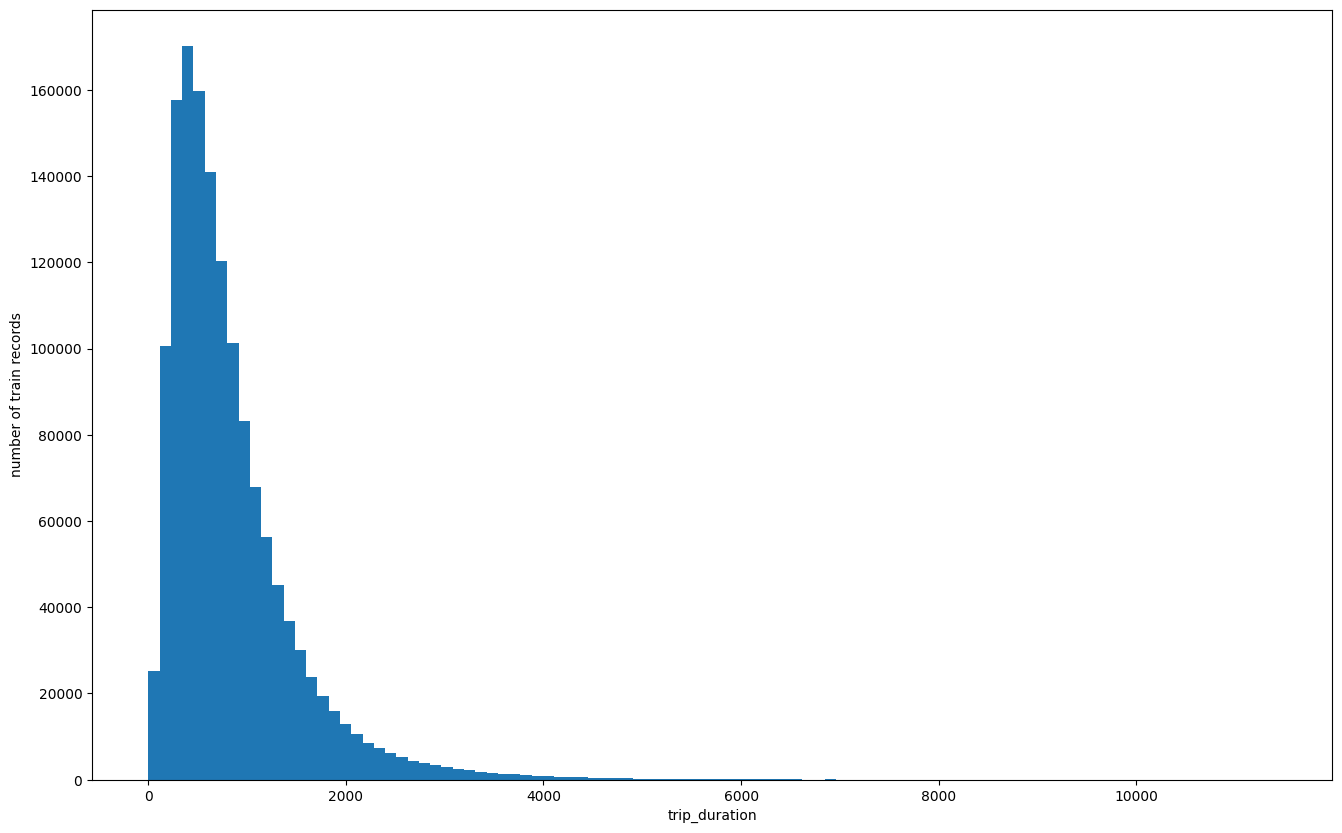

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

트립 지속 시간에 로그 변환을 적용

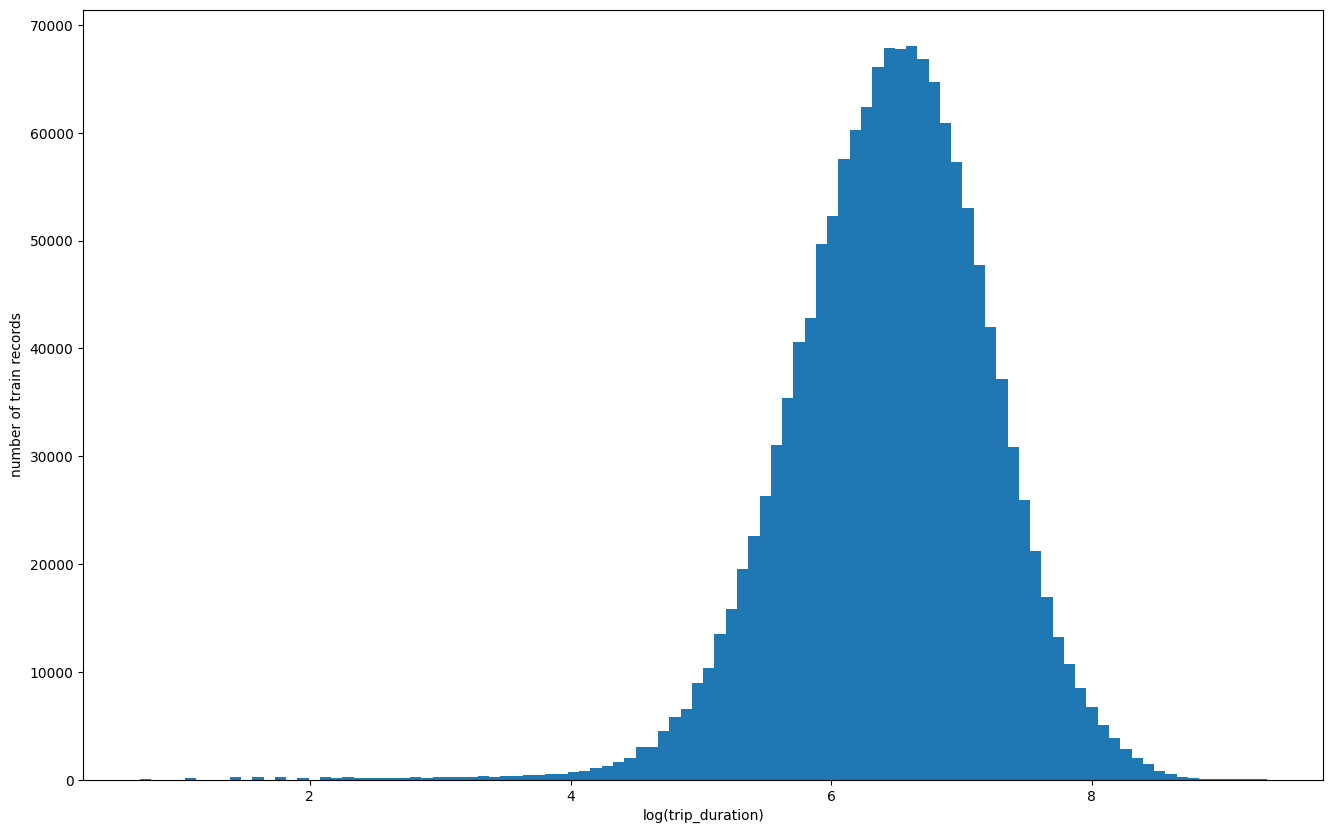

In [ ]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
# sns.displot(train["log_trip_duration"], bins =100)

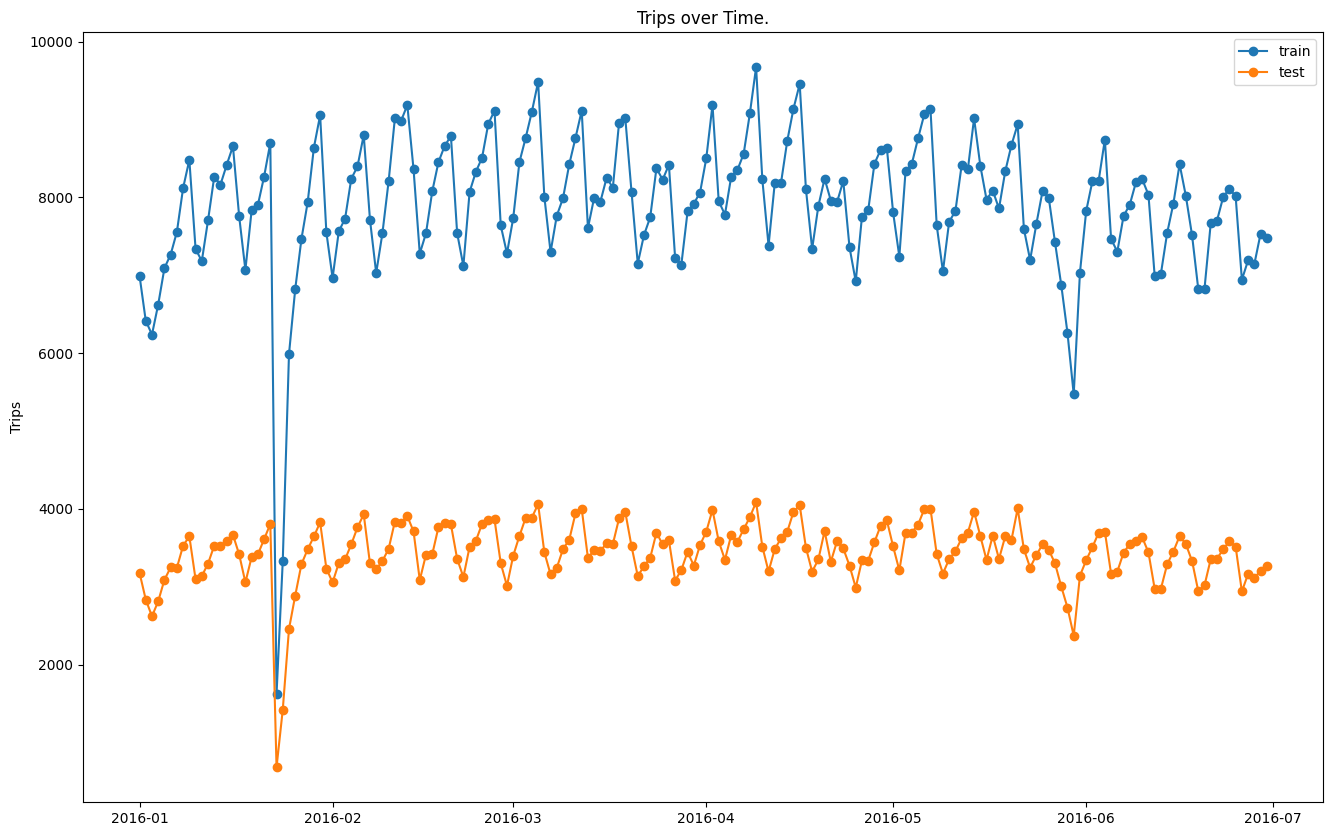

In [ ]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

테스트 및 훈련 데이터 세트는 예상대로 매우 유사한 모양을 따르고 있음이 분명하다.
 '이상치'에 주목할 필요가 있다.

Text(0, 0.5, 'Time in Seconds')

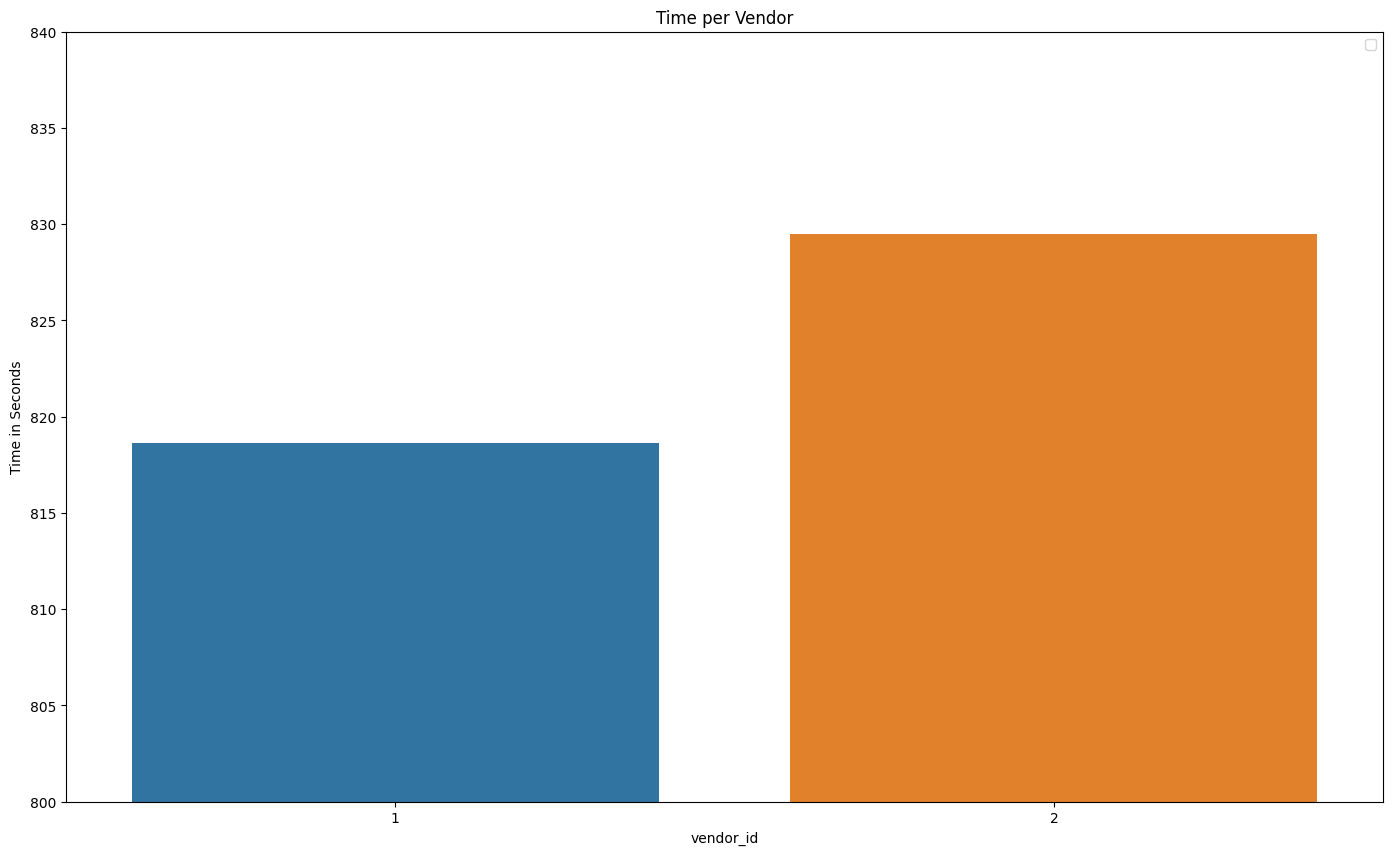

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(x=plot_vendor.index, y=plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

<Axes: title={'center': 'Time per store_and_fwd_flag'}, xlabel='store_and_fwd_flag', ylabel='Time in Seconds'>

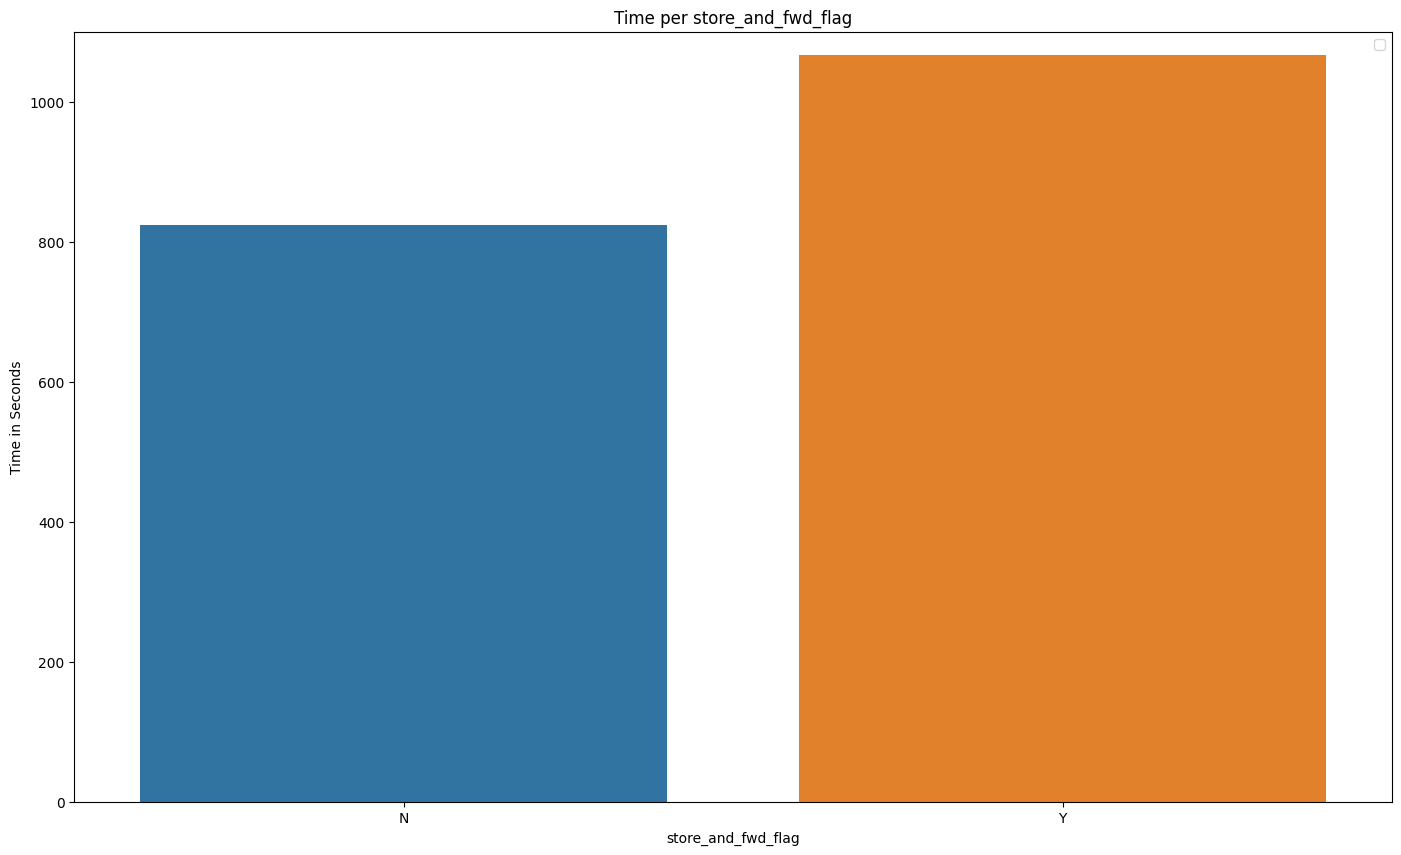

In [ ]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(x=snwflag.index, y=snwflag.values)

<Axes: title={'center': 'Time per store_and_fwd_flag'}, xlabel='passenger_count', ylabel='Time in Seconds'>

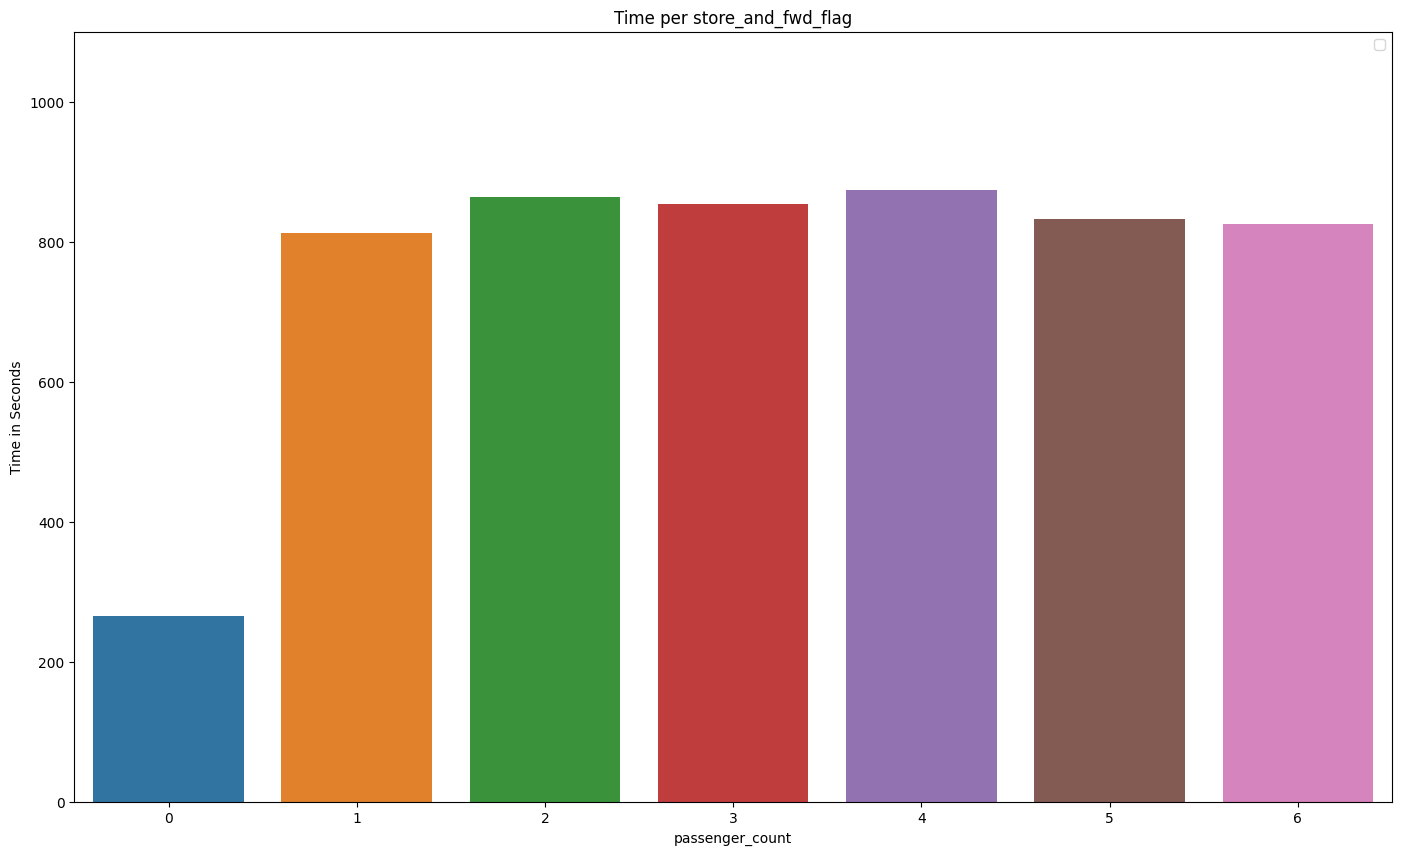

In [ ]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(x=pc.index,y=pc.values)

In [ ]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [ ]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

승객 수가 순서적이지 않다는 것을 알 수 있다. 9명의 승객을 태운 두 번의 여행에서 우리가 아직 다루지 않은 이상치 데이터가 있는 것 같다.    
그러나 그것을 제외하고는 두 데이터 집합 사이에서 상대적으로 카운트가 일치하는 것으로 보인다.    
다음 단계는 제공된 위도와 경도 데이터로 이동하여 이동 경로를 시각화하고 잠재적으로 데이터와 관련된 공간 구성 요소를 파악하기 위해 지도 보기를 만드는 것이다.

### 3.2 좌표 매핑

우리가 여행 시간 데이터와 테스트와 기차 세트 사이의 승객 수를 비교한 것처럼, 우리는 두 세트의 픽업 위치 데이터가 상당히 유사하고 서로를 대표하는지 확인하려고 시도할 수 있다.


#### 3.2.1 픽업 위치

이를 위해, 우리는 앞에서 커널에서 언급한 뉴욕의 도시 지도 경계 좌표를 사용하여 좌표점이 그래프로 그려진 캔버스를 만든다. 실제 좌표를 표시하기 위해 단순한 산점도를 사용한다:

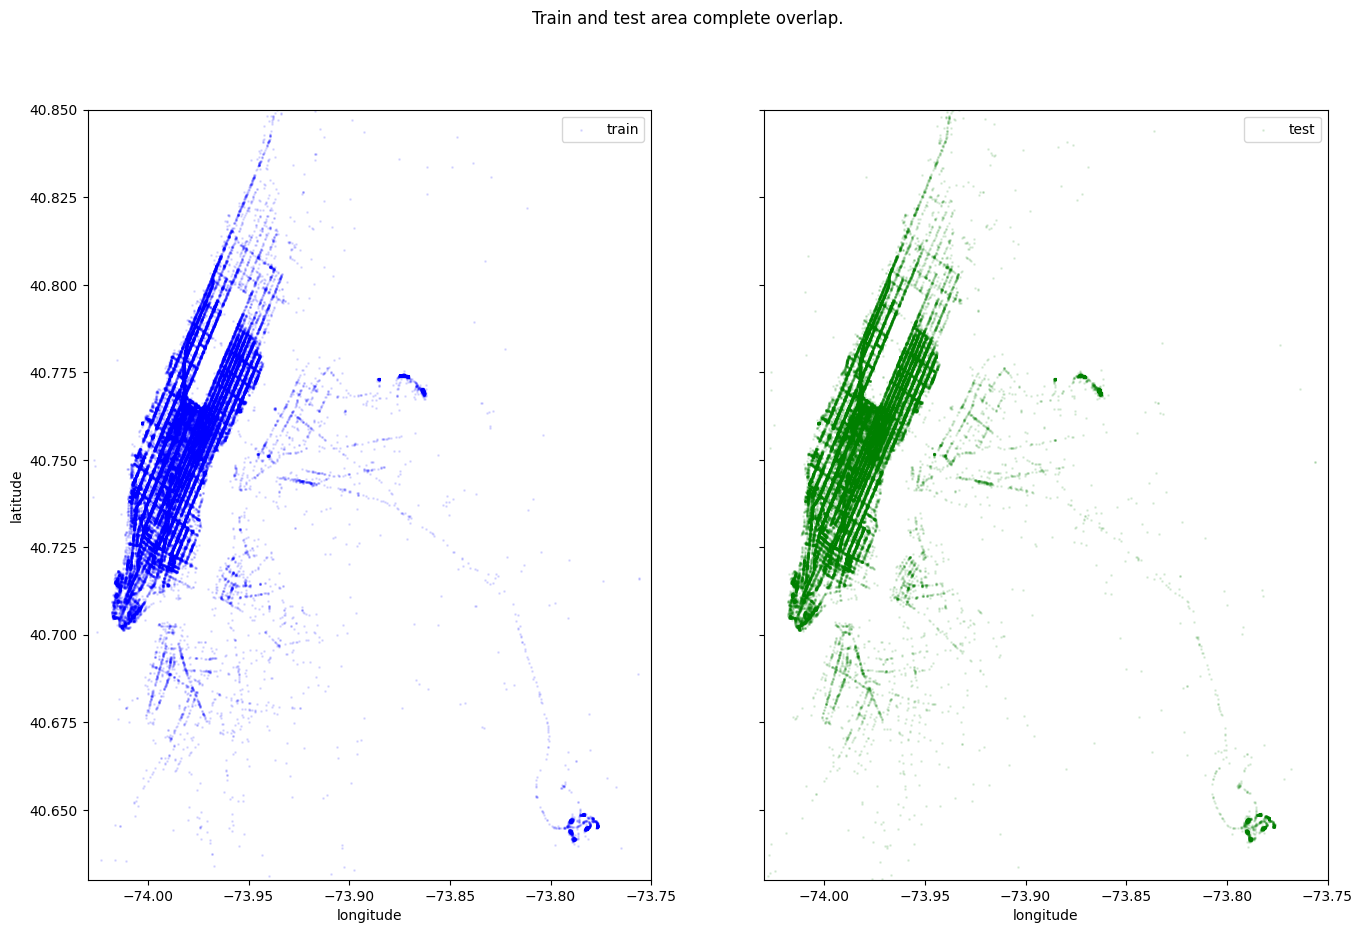

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

우리는 두 그래프에서 픽업 위치가 상당히 비슷하다는 것을 알 수 있으며, 주목할 만한 차이는 기차 데이터 세트에 단순히 더 많은 데이터 포인트가 있다는 것이다(이는 말이 된다).

3.2.2 거리 및 방향성

이 다음 부분은 꽤 흥미롭다. 벨루가의 게시물 덕분에, 우리는 픽업과 드롭오프 좌표를 기반으로 특정 여행의 거리와 방향을 결정할 수 있다. 이를 위해 나는 다음과 같이 세 가지 기능을 만들었다:

In [ ]:
#  Haversine(또는 큰 원) 거리는 구 표면의 두 지점 사이의 각도 거리
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

# 이동한 거리의 방향(또는 방위)
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

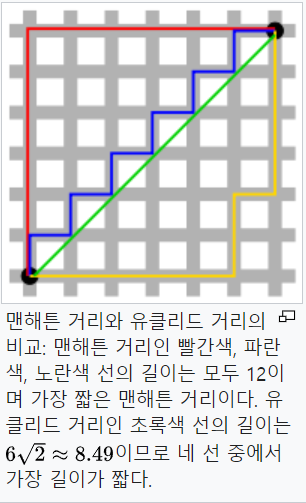

In [ ]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

#### 3.3.3 "이웃"을 만들자

이것을 수행하기 위해서는 지도를 가까이에 둘 필요가 있다고 생각할 수 있지만 실제로는 그렇지 않다. 이것은 **K-means**가 데이터 포인트를 자신의 이웃으로 **클러스터링** 할 것이기 때문에 직관적으로 작동할 것이다. Numpy는 픽업 및 드롭오프 좌표를 수직으로 적층한 배열을 만드는 데 도움이 되고 sklearn의 MiniBatchKmeans 모듈을 사용하면 매개변수를 설정하여 클러스터를 만드는 데 용이하기 때문에 매우 간단하다.

데이터를 준비하는 데는 좌표 스택 생성, KMeans 클러스터링 매개 변수 구성 및 실제 클러스터 생성의 세 단계가 있습니다:

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

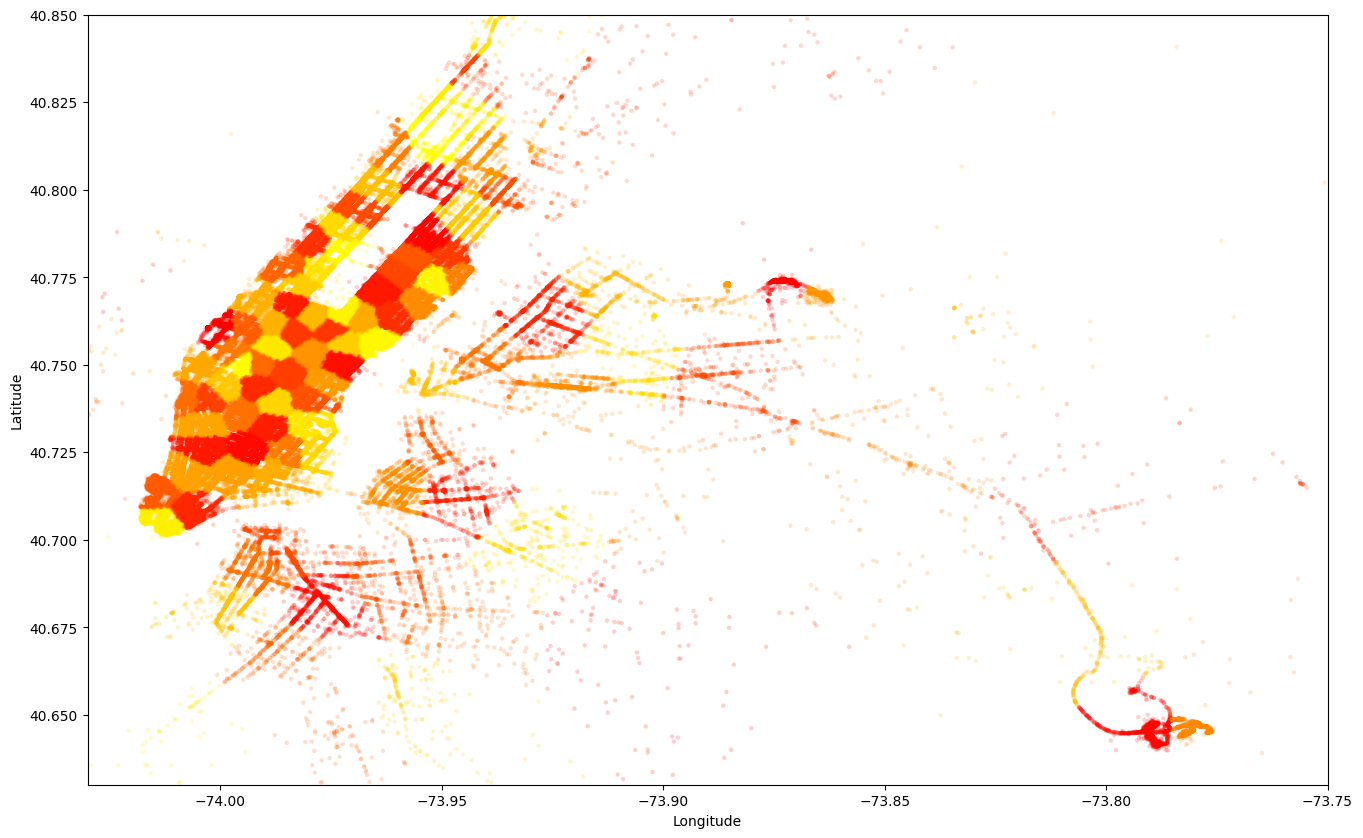

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### 3.4 날짜 추출

각 여행에서 날짜의 다른 부분을 추출하는 이유 중 하나는 우리가 하나의 핫 인코딩을 할 수 있도록 하기 위함이다. 이것은 범주형 변수를 이진 변수로 바꾸는 것을 포함한다. 예를 들어 논리적으로 기계는 1월이나 2월보다 1과 0을 훨씬 더 잘 이해할 수 있기 때문에 ML 모델을 훈련할 때 더 쉽게 사용할 수 있다. [여기](http://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/ "One Hot Encoding")에서 더 많이 읽을 수 있다. 날짜에서 추출한 기능을 사용하려면 두 데이터 집합의 크기가 같은지(즉, 월, 일, 시간 등)를 확인해야 한다.

In [ ]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [ ]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64,
 Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [ ]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [ ]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [ ]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

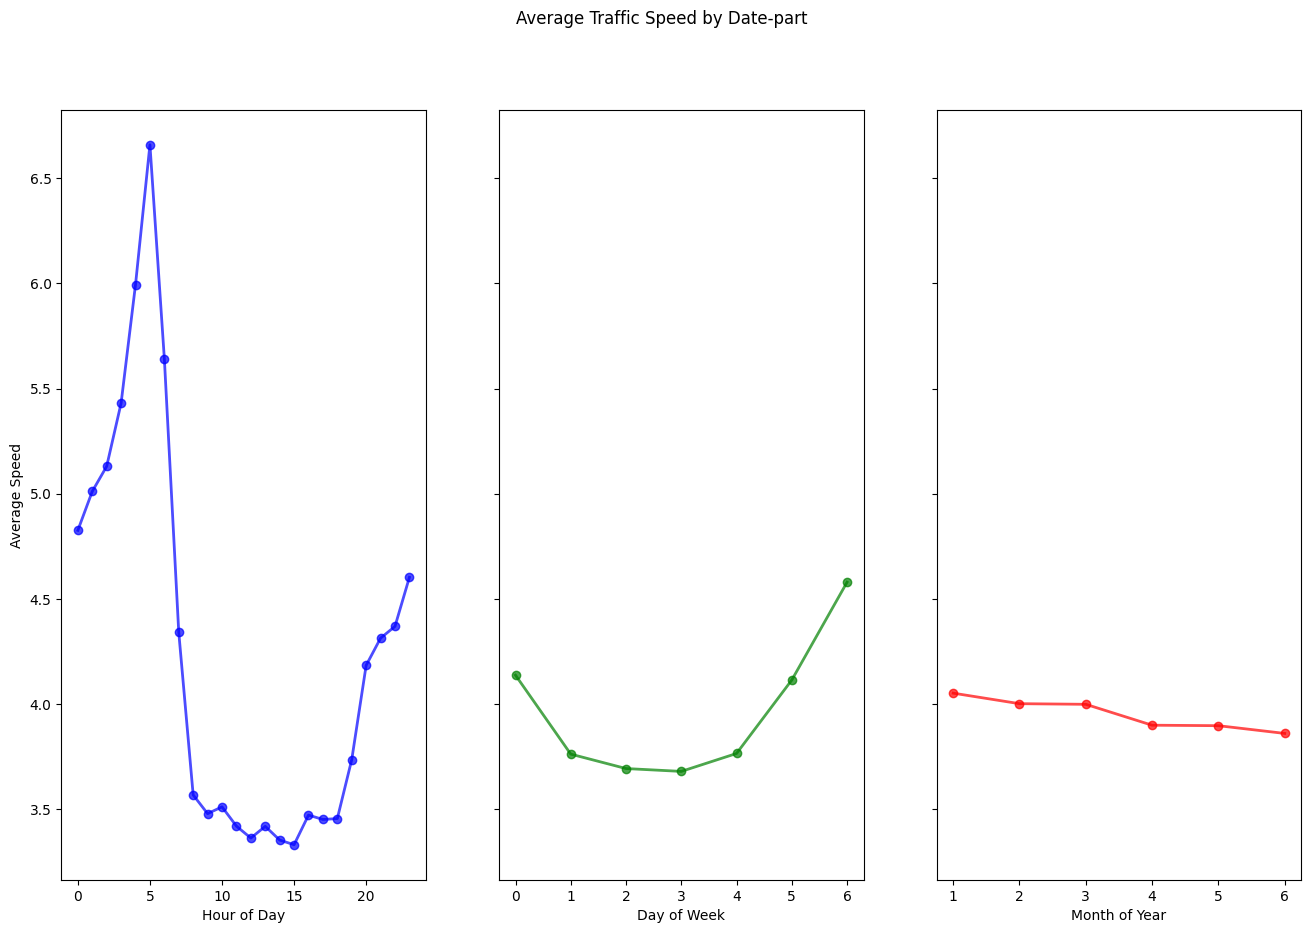

In [ ]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

그래서 여기서 주목해야 할 흥미로운 점은 **하루 평균 속도**이다. 우리는 교통량이 보통 **오전 5시에서 9시 사이**에 절정에 이르고, 다시 **오후 4시에서 6시나 7시 사이**에 절정에 이른다. 하지만 평균 속도는 하루가 오전 6시경부터 다시 오후 7시나 8시경에 절정에 이르면서 줄어드는 것처럼 보인다. 그래서 빅 애플에서의 대부분의 여행은 업무 시간 동안 이루어진다. 평일 평균 속도는 예상되는 추세를 따른다. 주말(금, 토, 일) 동안 평균 속도는 꽤 잘 회복되어 교통량이 적다는 것을 나타낸다. 마지막으로, 예상되는 추세를 따라 월 평균 여행 속도가 나타난다. 겨울에는 일반적으로 도시의 교통량이 적다는 것을 나타내는 여행(이전 시리즈 그림 참조)이 적으며, 이는 당신이 도로에서 더 빠른 속도를 평균할 수 있다는 것을 의미한다.


다음 부분에서는 픽업 위치와 평균 속도 데이터를 사용하여 위치별 평균 속도를 표시합니다.

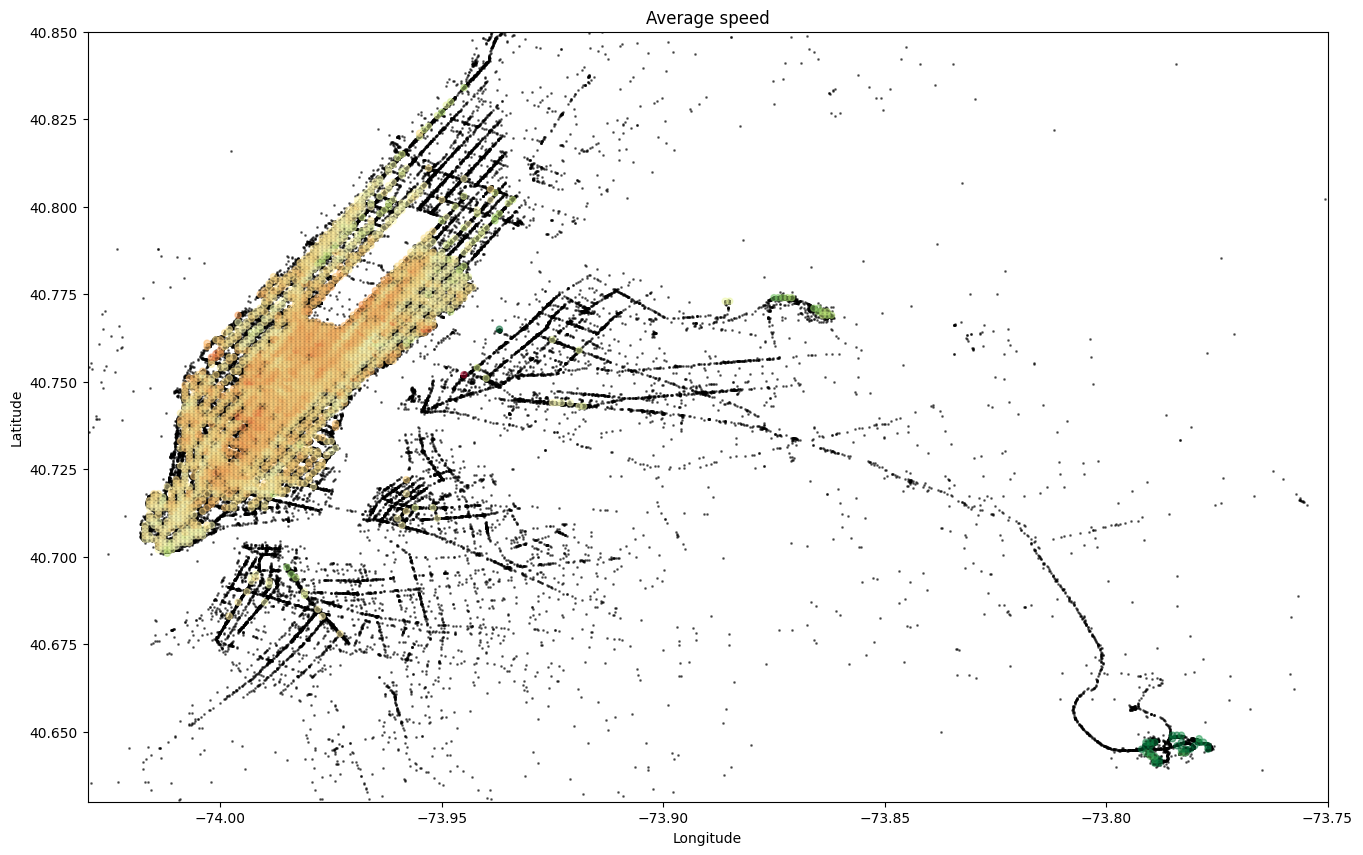

In [ ]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

그래서 분명히, 이웃별로, 평균 속도는 확실히 변한다. 대체로, 도시의 중심은 가장 붐비고 (큰 도시에서의 활동의 대부분이 중심에 집중되어 있기 때문에 우리는 이것을 예상한다), 평균 속도는 외곽에서 잘 회복된다.


우리는 이웃별(즉, 클러스터)로 평균 속도를 얼마나 잘 구별할 수 있는지 살펴보는 것만으로도 모델링하는 동안 클러스터링 데이터로부터 좋은 성능을 기대할 수 있다. XGBoost 모델의 성능을 크게 향상시킬 수 있는 확실히 탐색할 가치가 있는 것은 [Xiaolin Wu의 라인 알고리즘](https://en.m.wikipedia.org/wiki/Xiaolin_Wu%27s_line_algorithm "Xiaolin Wu의 라인 알고리즘")과 함께 사용할 수 있는 데이터 세트를 만드는 것이다. 여기에는 그래프 영역을 픽셀화하고 픽업 위치에서 드롭오프 위치까지 선이 교차하는 모든 픽셀을 기록하는 것이 포함될 것이다. 해상도를 가능한 한 높게 만들 수 있다면 픽셀 중 일부는 교통 교차로, 신호등, 다리 등을 캡슐화해야 한다. "교차 좌표 X" 기능을 사용하면 잠재적으로 알고리듬을 훈련하기 위해 +-10,000개의 추가 기능을 만들 수 있다.


** 참고:** XGBoost는 맥북 프로에서 약 100만 행의 데이터로 최대 약 10,000개의 열(기능)을 처리할 수 있습니다.

## 4. 데이터 농축 및 더미 변수
---------------------------------------
이 시점에서 우리의 모델을 훈련하는 것은 가능하지만, 데이터 과학과 다양한 데이터 세트를 분석하는 경우가 많다. 우리는 모델의 정확성을 높일 수 있는 더미 변수를 만들 기회는 여전히 있다.

### 4.1 데이터 농축(Enrichment)

이 특정 문제에 대해 우리는 OSRM([오픈 소스 라우팅 머신](http://project-osrm.org/ "OSRM") 기능을 추가할 수 있다. 궁극적으로 이것은 뉴욕의 특정 출발점에서 가장 빠른 경로를 포함하는 데이터 세트이다.

In [ ]:
train_street_info = pd.read_csv('/content/drive/MyDrive/Kaggle_study/NewYork_TaxiTrip_Duration/nyc_taxi_trip_duration/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])

test_street_info = pd.read_csv('/content/drive/MyDrive/Kaggle_study/NewYork_TaxiTrip_Duration/nyc_taxi_trip_duration/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [ ]:
train.shape, test.shape

((1437128, 29), (625134, 22))

### 4.2 Creating Dummy Variables

In [ ]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [ ]:
vendor_train.shape,vendor_test.shape

((1437128, 2), (625134, 2))

In [ ]:
passenger_count_train.shape,passenger_count_test.shape

((1437128, 7), (625134, 8))

In [ ]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

((1437128, 2), (625134, 2))

In [ ]:
cluster_pickup_train.shape,cluster_pickup_test.shape

((1437128, 100), (625134, 100))

In [ ]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

((1437128, 100), (625134, 100))

In [ ]:
month_train.shape,month_test.shape

((1437128, 6), (625134, 6))

In [ ]:
dom_train.shape,dom_test.shape

((1437128, 31), (625134, 31))

In [ ]:
hour_train.shape,hour_test.shape

((1437128, 24), (625134, 24))

In [ ]:
dow_train.shape,dow_test.shape

((1437128, 7), (625134, 7))

출력을 보면 승객 수를 제외하고 모든 것이 잘 일치함을 알 수 있습니다. 그러나 테스트 세트에 9명의 승객이 있는 두 번의 여행이 있었고 열차 세트에 9명의 승객이 있는 여행이 없었기 때문에 우리는 이것을 알고 있었습니다. 우리가 결론을 내린 것처럼 이것은 분명히 오류/이상치입니다.

In [ ]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

테스트 및 훈련 세트의 최종 버전을 컴파일하는 것이다.

In [ ]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [ ]:
train.shape,test.shape

((1437128, 11), (625134, 10))

In [ ]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [ ]:
Test_master = pd.concat([test,
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [ ]:
Train_Master.shape,Test_master.shape

((1437128, 290), (625134, 289))

In [ ]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [ ]:
Train_Master.shape,Test_master.shape

((1437128, 288), (625134, 287))

In [ ]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [ ]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

XGBoost를 사용하여 모델을 훈련시키는 데 사용될 XGBoost 행렬을 만들어야 한다.   
(훈련 및 검증을 위해) 새로 생성된 테스트 및 훈련 집합을 모델 훈련 입력으로 사용하고 마지막으로 마스터 테스트 집합을 사용하여 예측한다.

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

5. XGBoost - 모델 교육 및 정확도 테스트
언급한 것처럼 XGBoost 알고리즘의 다른 매개 변수를 가지고 모델의 결과를 조정할 수 있다. 아래는 모델 매개 변수를 반복적으로 사용하여 모델을 조정하는 짧지만 매우 좋은 방법이다. 구현 방법은 간단하다. 코드에 대한 설명을 풀고 커널을 실행하면 된다. 다시 [XGBoost용 설명서](http://xgboost.readthedocs.io/en/latest/python/python_intro.html "XGBoost 설명서")를 참조하여 각 매개 변수가 수행하는 작업과 훈련 과정의 동작을 어떻게 변경하는지 알아보자.

In [ ]:
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]
for m in md:
   for l in lr:
       for n in mcw:
           t0 = datetime.now()
           xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9,
                       'max_depth': m,
           'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
           'eval_metric': 'rmse', 'objective': 'reg:linear'}
           model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=1)

[06:53:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:5.40068	valid-rmse:5.40638
[1]	train-rmse:4.86460	valid-rmse:4.87029
[2]	train-rmse:4.38246	valid-rmse:4.38817
[3]	train-rmse:3.94895	valid-rmse:3.95462
[4]	train-rmse:3.55936	valid-rmse:3.56508
[5]	train-rmse:3.20926	valid-rmse:3.21495
[6]	train-rmse:2.89470	valid-rmse:2.90042
[7]	train-rmse:2.61215	valid-rmse:2.61796
[8]	train-rmse:2.35875	valid-rmse:2.36474
[9]	train-rmse:2.13134	valid-rmse:2.13737
[10]	train-rmse:1.92744	valid-rmse:1.93354
[11]	train-rmse:1.74474	valid-rmse:1.75097
[12]	train-rmse:1.58136	valid-rmse:1.58763
[13]	train-rmse:1.43529	valid-rmse:1.44183
[14]	train-rmse:1.30504	valid-rmse:1.31185
[15]	train-rmse:1.18903	valid-rmse:1.19617
[16]	train-rmse:1.08595	valid-rmse:1.09340
[17]	train-rmse:0.99444	valid-rmse:1.00226
[18]	train-rmse:0.91361	valid-rms

## XGBoost(eXtreme Gradient Boosting)
단순하고 약한 모델 세트의 추정치를 결합하여 대상 변수를 정확하게 예측하려 시도하는 지도 학습 알고리즘

In [ ]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9,
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[07:03:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:3.02453	valid-rmse:3.03062
[1]	train-rmse:1.55868	valid-rmse:1.56531
[2]	train-rmse:0.86256	valid-rmse:0.87114
[3]	train-rmse:0.56416	valid-rmse:0.57713
[4]	train-rmse:0.45857	valid-rmse:0.47433
[5]	train-rmse:0.42392	valid-rmse:0.44155
[6]	train-rmse:0.41341	valid-rmse:0.43249
[7]	train-rmse:0.40792	valid-rmse:0.42918
[8]	train-rmse:0.40475	valid-rmse:0.42856
[9]	train-rmse:0.40200	valid-rmse:0.42698
Modeling RMSLE 0.42698


중지하기 전에 10회 이상 반복하십시오.   
Eta 값을 낮추십시오.   
최대 깊이를 늘립니다.   
그러나 과적합과 같은 것이 있으므로 매우 조심하라.   
 즉, 모델을 훈련 세트에서 너무 잘 훈련시켜서 보이지 않는 데이터에 대해서는 수행이 매우 힘들다. 여기서 나는 과적합을 제어하기 위해 'colsample_bytree'와 'subsample'을 가지고 노는 것을 제안하고자 한다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

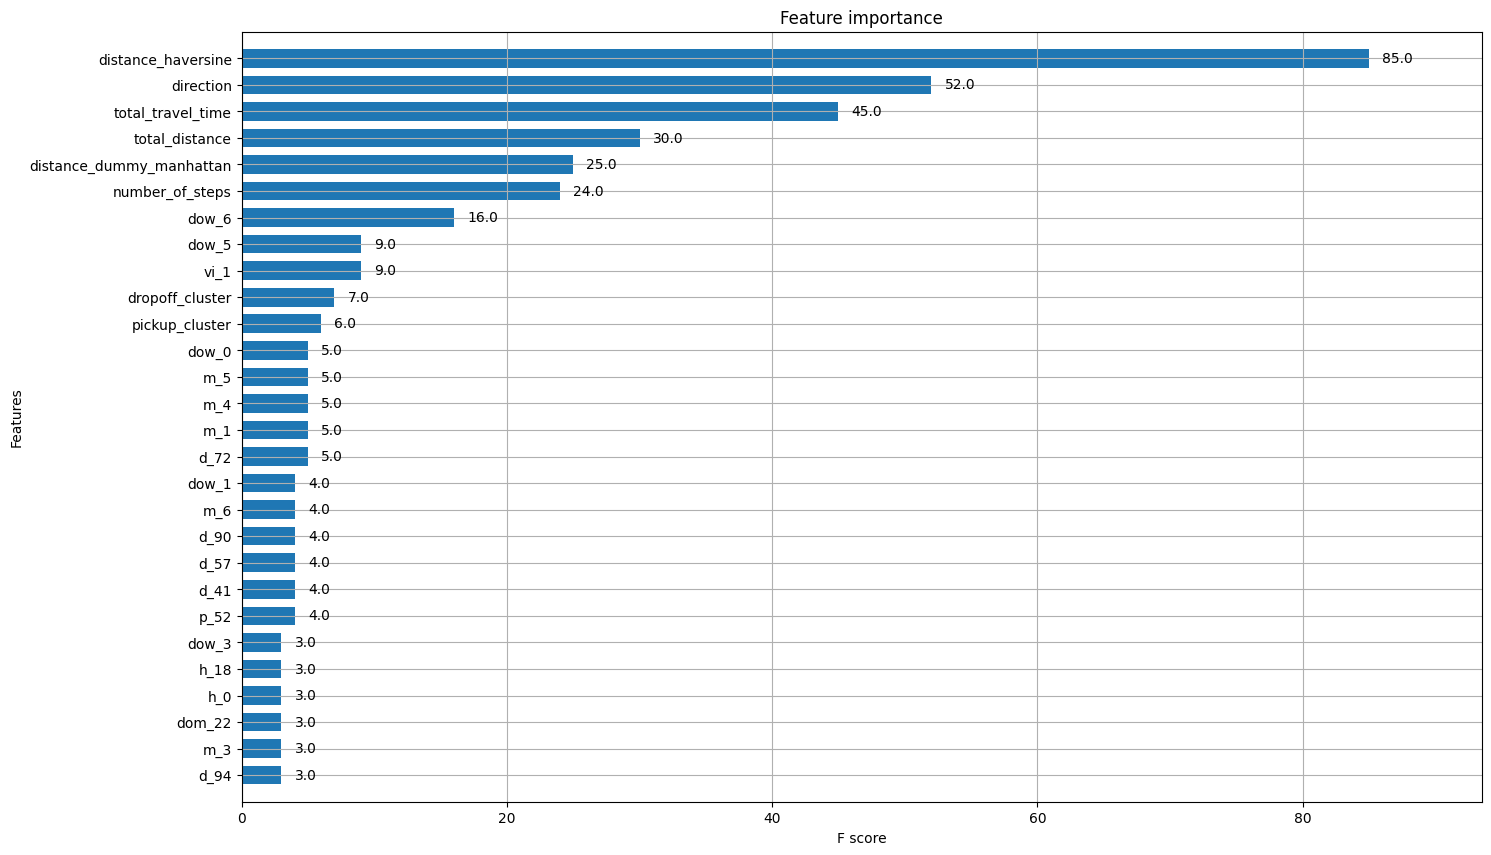

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

따라서 여행 기간에 가장 큰 영향을 미치는 기능이 위에서 아래로 표시됩니다. 거리가 가장 큰 영향을 미친다는 것은 논리적으로 이해할 수 있습니다. 멀리 여행할수록 더 오래 걸립니다.


In [ ]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [ ]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)